# Predicting High-Demand Airbnb Listings

## Project Overview
This project builds a machine learning pipeline to predict whether an Airbnb listing will experience high booking demand using listing characteristics, pricing, reviews, availability, and host attributes.. 
The goal is to help hosts optimize pricing, improve visibility, and increase booking likelihood.
Identifying high-demand listings manually is difficult due to the large number of features influencing booking behavior. Machine learning enables automated and scalable demand prediction.


## Dataset
The dataset contains Airbnb listings with information about pricing, location, reviews, availability, and host characteristics.  
These features are used to model and predict listing demand.


# Target Variable
The dataset does not include a direct measure of demand.
To address this,a new target variable, **high_demand** was created using listing availability as a proxy for booking activity.


---

In [34]:
# Create .gitignore file for GitHub
gitignore_content = """
data/
*.csv
*.png
*.jpg
*.jpeg
*.joblib
.ipynb_checkpoints/
"""

with open(".gitignore", "w") as f:
    f.write(gitignore_content)

print(".gitignore created successfully")


.gitignore created successfully


## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score



In [2]:
df = pd.read_csv("../data/Airbnb_Open_Data.csv", low_memory=False)


In [3]:
df.head()

,id,NAME,host id,host_identity_verified,host name,neighbourhood group,neighbourhood,lat,long,country,...,service fee,minimum nights,number of reviews,last review,reviews per month,review rate number,calculated host listings count,availability 365,house_rules,license
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,...,$193,10.0,9.0,10/19/2021,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...,NaN
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,...,$28,30.0,45.0,5/21/2022,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...,NaN
2,1002403,THE VILLAGE OF HARLEM....NEW YORK !,78829239556,NaN,Elise,Manhattan,Harlem,40.80902,-73.94190,United States,...,$124,3.0,0.0,NaN,NaN,5.0,1.0,352.0,"I encourage you to use my kitchen, cooking and...",NaN
3,1002755,NaN,85098326012,unconfirmed,Garry,Brooklyn,Clinton Hill,40.68514,-73.95976,United States,...,$74,30.0,270.0,07/05/2019,4.64,4.0,1.0,322.0,NaN,NaN
4,1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,United States,...,$41,10.0,9.0,11/19/2018,0.10,3.0,1.0,289.0,"Please no smoking in the house, porch or on th...",NaN


In [4]:
df.shape

(102599, 26)

In [5]:
df.columns

Index(['id', 'NAME', 'host id', 'host_identity_verified', 'host name',
       'neighbourhood group', 'neighbourhood', 'lat', 'long', 'country',
       'country code', 'instant_bookable', 'cancellation_policy', 'room type',
       'Construction year', 'price', 'service fee', 'minimum nights',
       'number of reviews', 'last review', 'reviews per month',
       'review rate number', 'calculated host listings count',
       'availability 365', 'house_rules', 'license'],
      dtype='object')

In [6]:
df.columns = df.columns.str.strip().str.lower()

cols_to_drop = [
        "license",
        "service fee",
        "house_rules",
        "last review",
        "reviews per month"
    ]
    
df = df.drop(columns=cols_to_drop, errors="ignore")



In [7]:
df.isna().sum().sort_values(ascending=False)


country                           532
availability 365                  448
minimum nights                    409
host name                         406
review rate number                326
calculated host listings count    319
host_identity_verified            289
name                              250
price                             247
construction year                 214
number of reviews                 183
country code                      131
instant_bookable                  105
cancellation_policy                76
neighbourhood group                29
neighbourhood                      16
long                                8
lat                                 8
room type                           0
host id                             0
id                                  0
dtype: int64

In [8]:
df["price"] = (
    df["price"]
    .astype(str)
    .str.replace("$", "", regex=False)
    .str.replace(",", "", regex=False)
)


In [9]:
df["price"] = pd.to_numeric(df["price"], errors="coerce")


In [10]:
df["host_identity_verified"] = (
    df["host_identity_verified"]
    .astype(str)
    .str.strip()
    .str.lower()
)


## Feature Engineering

The dataset does not include a direct measure of demand.  
To approximate demand, we created a proxy variable called #booking_pressure# based on listing availability.
Listings that are available fewer days per year are likely booked more often, indicating higher demand.
We then converted this continuous measure into a binary classification target called #high_demand# using the median value.


In [11]:
df["booking_pressure"] = 1 - (df["availability 365"] / 365)


In [12]:
df["high_demand"] = (
    df["booking_pressure"] > df["booking_pressure"].median()
).astype(int)


## Exploratory Data Analysis

To better understand demand patterns, we explore the distribution of high-demand listings and key relationships between pricing and booking behavior.


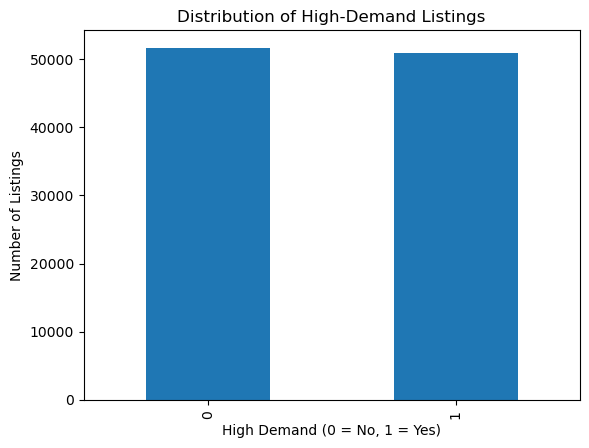

In [13]:
df["high_demand"].value_counts().plot(kind="bar")
plt.title("Distribution of High-Demand Listings")
plt.xlabel("High Demand (0 = No, 1 = Yes)")
plt.ylabel("Number of Listings")
plt.show()


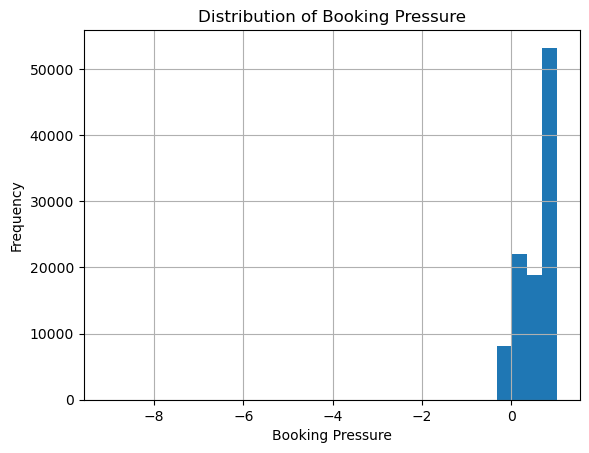

In [14]:
df["booking_pressure"].hist(bins=30)
plt.title("Distribution of Booking Pressure")
plt.xlabel("Booking Pressure")
plt.ylabel("Frequency")
plt.show()


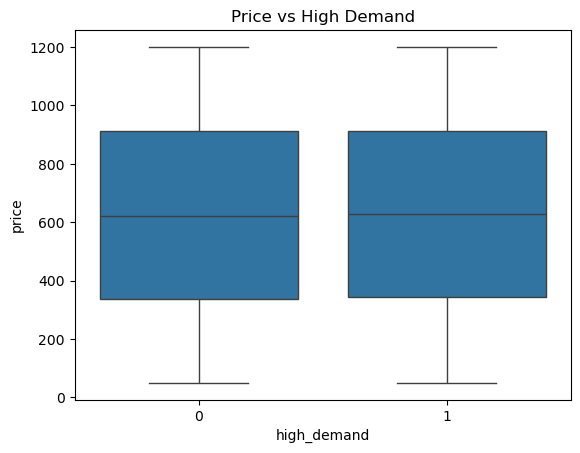

In [15]:
sns.boxplot(x="high_demand", y="price", data=df)
plt.title("Price vs High Demand")
plt.show()


## Feature Selection 

In [16]:
features = [
    "price",
    "minimum nights",
    "number of reviews",
    "review rate number",
    "calculated host listings count",
    "construction year",
    "room type",
    "neighbourhood group",
    "cancellation_policy",
    "instant_bookable",
    "host_identity_verified"
]


In [17]:
X = df[features]
y = df["high_demand"]


In [18]:
categorical_cols = [
    "room type",
    "neighbourhood group",
    "cancellation_policy",
    "instant_bookable",
    "host_identity_verified"
]

numeric_cols = [
    "price",
    "minimum nights",
    "number of reviews",
    "review rate number",
    "calculated host listings count",
    "construction year",
]
X = df[categorical_cols + numeric_cols]
y = df["high_demand"]

## Train-Test Split

The dataset was split into training and testing sets to evaluate model performance on unseen data.
Stratified sampling was used to preserve class balance.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


## Preprocessing Pipeline

To ensure reproducible and scalable modeling, a preprocessing pipeline was built using scikit-learn's `ColumnTransformer` and `Pipeline`.

This pipeline handles:
- Missing value imputation
- Feature scaling for numerical variables
- One-hot encoding for categorical variables

Using a pipeline ensures that preprocessing is consistently applied during both training and prediction.


In [20]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])


In [21]:
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])


In [22]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)


In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


## Logistic Regression Model

Logistic Regression was used as a baseline model due to its interpretability and strong performance on structured tabular data.Class weighting was applied to address class imbalance and improve recall for high_demand listings.

In [24]:
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(class_weight="balanced", max_iter=1000))
])


In [25]:
model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['price', 'minimum nights',
                                                   'number of reviews',
                                                   'review rate number',
                                                   'calculated host listings '
                                                   'count',
                                                   'construction year']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['room type',
                                                   'neighbourhood group',
                                                   'cancellation_policy',
                                                   'instant_bookable',
                                                   'host_identity_verified'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [26]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.6065789473684211
              precision    recall  f1-score   support

           0       0.65      0.46      0.54     10332
           1       0.58      0.75      0.65     10188

    accuracy                           0.61     20520
   macro avg       0.62      0.61      0.60     20520
weighted avg       0.62      0.61      0.60     20520




Logistic Regression coefficients provide interpretability by showing which features increase or decrease the probability of high demand.

In [27]:
feature_names = model.named_steps["preprocessor"].get_feature_names_out()
coefs = model.named_steps["classifier"].coef_[0]

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefs
}).sort_values(by="coefficient", ascending=False)

display(coef_df.head(5))
display(coef_df.tail(5))


,feature,coefficient
11,cat__neighbourhood group_Brooklyn,0.326218
12,cat__neighbourhood group_Manhattan,0.269415
8,cat__room type_Private room,0.241950
6,cat__room type_Entire home/apt,0.117498
15,cat__neighbourhood group_brookln,0.034005


,feature,coefficient
1,num__minimum nights,-0.270889
2,num__number of reviews,-0.308372
4,num__calculated host listings count,-0.556908
14,cat__neighbourhood group_Staten Island,-0.569102
7,cat__room type_Hotel room,-0.589473


## Random Forest Model

Random Forest was trained to capture complex and non-linear relationship between listing features and demand.
This model typically provides stronger predictive performance compared to linear models.

In [28]:
rf_model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced"))
])


In [29]:
rf_model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['price', 'minimum nights',
                                                   'number of reviews',
                                                   'review rate number',
                                                   'calculated host listings '
                                                   'count',
                                                   'construction year']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['room type',
                                                   'neighbourhood group',
                                                   'cancellation_policy',
                                                   'instant_bookable',
                                                   'host_identity_verified'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=200, random_state=42))])

In [30]:
y_pred_rf = rf_model.predict(X_test)


In [31]:
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Accuracy: 0.6779727095516569
              precision    recall  f1-score   support

           0       0.69      0.66      0.67     10332
           1       0.67      0.70      0.68     10188

    accuracy                           0.68     20520
   macro avg       0.68      0.68      0.68     20520
weighted avg       0.68      0.68      0.68     20520



The model achieves balanced precision and recall, indicating reliable identification of both high- and low-demand listings.

## Feature Importance
Random Forest provides insight into which features most strongly influence the probability of high demand.


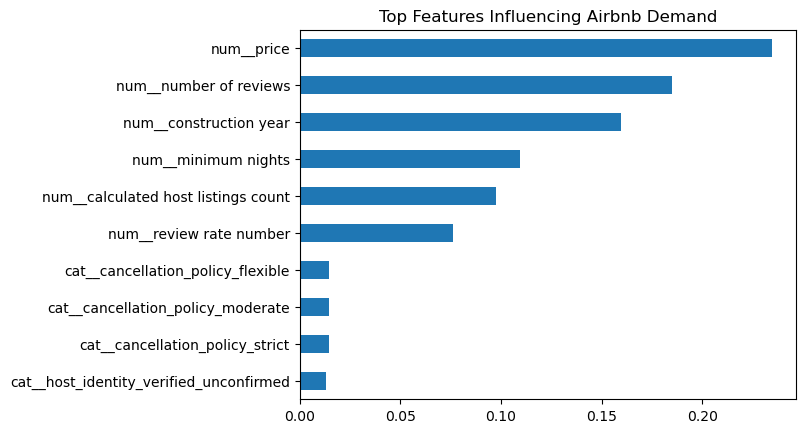

In [32]:
feature_names = rf_model.named_steps["preprocessor"].get_feature_names_out()
importances = rf_model.named_steps["classifier"].feature_importances_

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

feat_imp.head(10).plot(kind="barh")
plt.title("Top Features Influencing Airbnb Demand")
plt.gca().invert_yaxis()
plt.show()


## Model Comparison

In [33]:
comparison = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest"],
    "Accuracy": [
        accuracy_score(y_test, y_pred),
        accuracy_score(y_test, y_pred_rf)
    ],
    "Recall (High Demand)": [
        recall_score(y_test, y_pred),
        recall_score(y_test, y_pred_rf)
    ],
    "F1 Score": [
        f1_score(y_test, y_pred),
        f1_score(y_test, y_pred_rf)
    ]
})

comparison


,Model,Accuracy,Recall (High Demand),F1 Score
0,Logistic Regression,0.606579,0.750883,0.654601
1,Random Forest,0.677973,0.697880,0.682735


Random Forest achieved higher accuracy and F1-score compared to Logistic Regression, indicating a stronger ability to capture complex and non-linear relationships between listing features and demand.

While Logistic Regression offered interpretability through feature coefficients, Random Forest provided superior predictive performance. Therefore, Random Forest was selected as the preferred model for identifying high-demand Airbnb listings.

 ## Business Insights
 Key Insights for Airbnb Hosts

• Competitive pricing strongly influences demand: Listings priced appropriately relative to the market are more likely to attract bookings.

• Guest satisfaction drives visibility and bookings: Listings with more reviews and higher ratings experience greater demand.

• Instant booking reduces friction: Enabling instant booking increases the likelihood of reservations.

• Property type matters: Entire homes and private rooms show higher demand compared to shared spaces.

• Host credibility increases trust:  Verified hosts are more likely to attract bookings.


## Project Limitations & Future Work

This project uses availability as a proxy for demand, which may not capture seasonal trends or external factors such as location popularity or events.

Future improvements could include time-based features, location clustering, and hyperparameter tuning using cross-validation to further improve model performance and robustness.


## Conclusion

In this project, we developed a machine learning pipeline to predict high-demand Airbnb listings using listing characteristics and host attributes.

After comparing Logistic Regression and Random Forest models, Random Forest demonstrated superior predictive performance. The results provide actionable insights for Airbnb hosts to optimize pricing, improve guest experience, and increase booking likelihood.